In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors

# cell = 0 - out of board
# cell = 1 - board
# cell > 1 - piece
# different pieces should be 10 100 1000 .... to be able to differentiate when they are stacked

class Cell:
    def __init__(self, q, r, s):
        if (q + r + s) != 0:
            raise ValueError("Invalid cell: q+r+s!=0")
        self.q = q
        self.r = r
        self.s = s

    def __eq__(self, other):
        return isinstance(other, Cell) and (self.q, self.r, self.s) == (other.q, other.r, other.s)

    def __hash__(self):
        return hash((self.q, self.r, self.s))

    def print_cell(self):
        print("({}, {}, {})".format(self.q, self.r, self.s))

class Piece:
    def __init__(self, piece_type):
        self.type = piece_type

    def get_allowed_moves(self, board_state):
        raise NotImplementedError

class Board:
    #TODO Maybe it is possible to represent board using sparse matrices
    def __init__(self, halfwidth, cell_size,  canvas_size = 20):
        self.halfwidth = halfwidth
        self.cell_size = cell_size
        self.size = 2 * self.halfwidth + 1
        self.board = np.zeros((self.size, self.size, self.size))
        self.ax = None
        self.canvas_size = canvas_size

        for i in range(self.size):
            for j in range(self.size):
                for k in range(self.size):
                    try:
                        self.array_to_board(i, j, k)
                        self.board[i, j, k] = 1
                    except:
                        pass

    def _ensure_ax(self):
        """Internal method to create a shared Axes if it doesn't exist."""
        if self.ax is None:
            fig, self.ax = plt.subplots(figsize=(15,15), facecolor='white')
            self.ax.set_xlim(0, self.canvas_size)
            self.ax.set_ylim(0, self.canvas_size)
            self.ax.set_aspect('equal')
            self.ax.axis('off')
        return self.ax

    def board_to_array(self, cell):
        if (abs(cell.q)*2+1 > self.size or
            abs(cell.r)*2+1 > self.size or
            abs(cell.s)*2+1 > self.size):
            raise ValueError('Coordinates out of active board!')
        i = self.halfwidth + cell.q
        j = self.halfwidth + cell.r
        k = self.halfwidth + cell.s
        return i, j, k

    def array_to_board(self, i, j ,k):
        if i < 0 or j <0 or k < 0:
            raise ValueError('Array indices has to be positive!')
        if i + 1 >  self.size or j + 1 > self.size or k + 1 > self.size:
            raise ValueError('Array indices out of active board!')
        q = i - self.halfwidth
        r = j - self.halfwidth
        s = k - self.halfwidth
        if q + r + s != 0:
            raise ValueError('Invalid cell: q+r+s!=0')
        cell = Cell(q, r, s)
        return cell

    def cell_corners(self, cx, cy):
        corners = []
        for i in range(6):
            angle = math.radians(60 * i - 30)  # pointy-top
            x = cx + self.size * math.cos(angle)
            y = cy + self.size * math.sin(angle)
            corners.append((x, y))
        return corners

    @staticmethod
    def get_neighbours(cell):
        neighbours = [Cell(cell.q + 1, cell.r - 1, cell.s    ),
                      Cell(cell.q + 1, cell.r    , cell.s - 1),
                      Cell(cell.q - 1, cell.r + 1, cell.s    ),
                      Cell(cell.q - 1, cell.r    , cell.s + 1),
                      Cell(cell.q    , cell.r + 1, cell.s - 1),
                      Cell(cell.q    , cell.r - 1, cell.s + 1)]
        return neighbours

    def has_piece(self, cell):
        i, j, k = self.board_to_array(cell)
        if self.board[i, j, k] > 1:
            return True
        else:
            return False

    def get_empty_neighbours(self, cell):
        neighbours = self.get_neighbours(cell)
        empty_neighbours = []
        for neighbour in neighbours:
            if not self.has_piece(neighbour):
                empty_neighbours.append(neighbour)
        return empty_neighbours

    def get_occupied_neighbours(self, cell):
        neighbours = self.get_neighbours(cell)
        occupied_neighbours = []
        for neighbour in neighbours:
            if self.has_piece(neighbour):
                occupied_neighbours.append(neighbour)
        return occupied_neighbours

    def get_cell_value(self, cell):
        i, j, k = self.board_to_array(cell)
        return self.board[i, j, k]

    @staticmethod
    def compare_cells(cell1, cell2):
        if cell1.q == cell2.q and cell1.r == cell2.r and cell1.s == cell2.s:
            return True
        else:
            return False

    @staticmethod
    def cube_to_axial(q, r ,s):
        return q, r

    @staticmethod
    def axial_to_cube(q, r):
        s = -q-r
        return q, r, s

    @staticmethod
    def print_cells(cells):
        for cell in cells:
            cell.print_cell()

    def cube_to_cartesian(self, q, r ,s):
        x = (math.sqrt(3) * self.size * self.cube_to_axial(q, r, s)[0] +
             math.sqrt(3)/2 * self.size * self.cube_to_axial(q, r, s)[1])
        y = 3/2 * self.size * self.cube_to_axial(q, r, s)[1]
        return x, y

    def get_occupied_cells(self):
        occupied_cells = []
        for i in range(self.size):
            for j in range(self.size):
                for k in range(self.size):
                    if self.board[i, j, k] > 1:
                        occupied_cells.append(self.array_to_board(i, j, k))
        return occupied_cells

    def get_outer_border(self):
        outer_border = []
        occupied_cells = self.get_occupied_cells()
        for occupied_cell in occupied_cells:
            neighbours = self.get_neighbours(occupied_cell)
            for neighbour in neighbours:
                if not self.has_piece(neighbour):
                    not_in_outer_border = True
                    for cell in outer_border:
                        if self.compare_cells(cell, neighbour):
                            not_in_outer_border = False
                    if not_in_outer_border:
                        outer_border.append(neighbour)
        return outer_border

    def draw_cell(self, cell, show = False, border_color='black',
                  fill_color='white', fill_alpha=1):
        ax = self._ensure_ax()
        cx = self.cube_to_cartesian(cell.q, cell.r, cell.s)[0]
        cy = self.cube_to_cartesian(cell.q, cell.r, cell.s)[1]
        centre = self.canvas_size/2
        rgba_fill = mcolors.to_rgba(fill_color, fill_alpha)
        hexagon = Polygon(self.cell_corners(centre  + cx, centre + cy),
                          closed=True, edgecolor=border_color, facecolor=rgba_fill)
        ax.add_patch(hexagon)
        if show:
            plt.show()
            return 0
        else:
            return ax

    def draw_cells(self,cells, border_color='black', fill_color='white', fill_alpha=1):
        for cell in cells:
            self.draw_cell(cell,border_color = border_color, fill_color = fill_color,
                           fill_alpha = fill_alpha)
        return

    def place_piece(self,cell, piece_value):
        i, j, k = self.board_to_array(cell)
        self.board[i, j, k] += piece_value
        return

    def remove_piece(self,cell, piece_value = 2):
        i, j, k = self.board_to_array(cell)
        self.board[i, j, k] -= piece_value
        return

    #TODO Make sure that this works with pieces that can move on top of others
    def move_piece(self, current_cell, new_cell, piece_value):
        if self.get_cell_value(current_cell) != piece_value + 1:
            print("Invalid move: Cell doesn't contain piece.")
            return False
        if self.get_cell_value(new_cell) != 1:
            print("Invalid move: Target cell is not empty.")
            return False
        i1, j1, k1 = self.board_to_array(current_cell)
        self.board[i1, j1, k1] -= piece_value
        i2, j2, k2 = self.board_to_array(new_cell)
        self.board[i2, j2, k2] += piece_value
        return True


    def draw_board(self):
        for i in range(self.size):
            for j in range(self.size):
                for k in range(self.size):
                    if self.board[i, j, k] != 0:
                        cell = self.array_to_board(i, j, k)
                        if self.board[i, j, k] == 1:
                            self.draw_cell(cell, fill_alpha=0)
                        if self.board[i, j, k] == 2:
                            self.draw_cell(cell, fill_color='orange')
                        if self.board[i, j, k] == 3:
                            self.draw_cell(cell, fill_color='yellow')
                        if self.board[i, j, k] == 4:
                            self.draw_cell(cell, fill_color='blue')

    def show_board(self):
        if self.ax is None:
            self._ensure_ax()
        plt.show()

    def get_connected_cells(self, start_cell, visited=None):
        if visited is None:
            visited = set()
        visited.add(start_cell)
        for neighbour in self.get_occupied_neighbours(start_cell):
            if neighbour not in visited:
                self.get_connected_cells(neighbour, visited)
        return visited

    def is_valid_state(self):
        occupied_cells = self.get_occupied_cells()
        if len(occupied_cells) == len(self.get_connected_cells(occupied_cells[0])):
            return True
        else:
            return False

class Game(Board):
    def __init__(self, cube, board_size = 8):
        self.cube = cube
        self.board_size = board_size


Invalid move: Target cell is not empty.


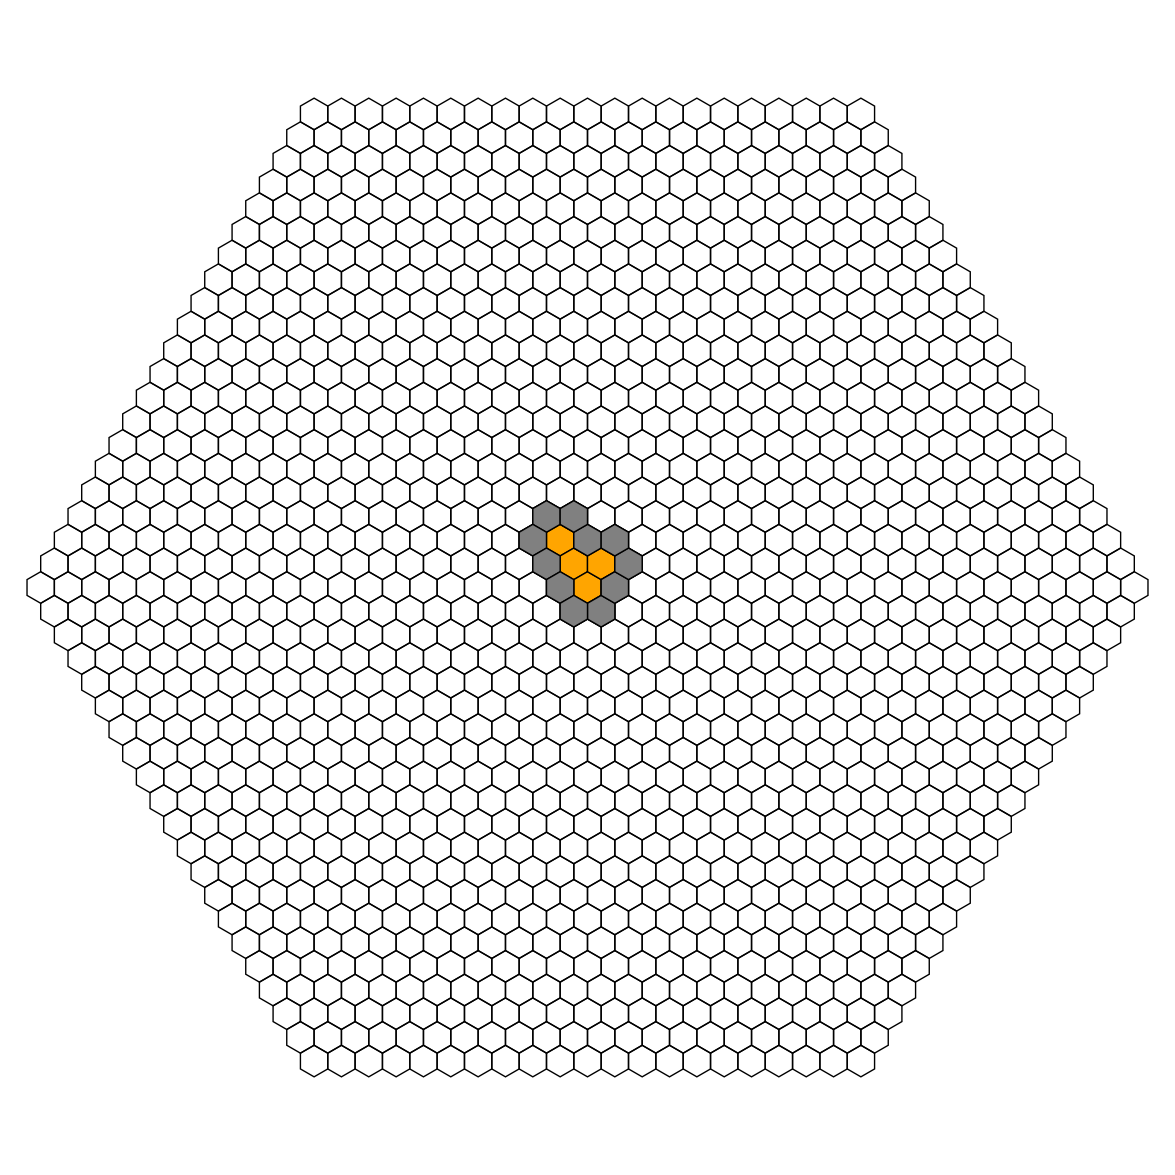

True

In [2]:
board_halfwidth_t = 20
cell_size_t = 1
canvas_size_t = 15
board_size_t = 2 * board_halfwidth_t + 1
board = np.zeros((board_size_t, board_size_t, board_size_t))

c1 = Cell(0,0,0)
c2 = Cell(-2,+2,0)
c3 = Cell(4,+1,-5)
c4 = Cell(0,1,-1)
c5 = Cell(-1,1,0)
b = Board(board_halfwidth_t, 0.5, canvas_size= 3000)
#b.draw_cells(c1.get_neighbours(), fill_color='red')
#b.draw_cell(c1, fill_color='green')
b.place_piece(c1,piece_value=1)
b.place_piece(c2,piece_value=1)
b.move_piece(c1,c1, piece_value=1)
b.place_piece(c5,piece_value=1)
b.place_piece(c4,piece_value=1)
b.draw_board()
#b.draw_cells(b.get_occupied_cells(), fill_color='red')
b.draw_cells(b.get_outer_border(), fill_color='grey')
b.print_cells(b.get_occupied_neighbours(c3))
b.show_board()
b.is_valid_state()

